In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, model_selection, preprocessing, pipeline, compose

import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
used_car = pd.DataFrame()

for dirname, _, filenames in os.walk('/content/drive/MyDrive/used_car'):
    for filename in filenames:
            each_car = pd.read_csv(os.path.join(dirname, filename), encoding='utf-8')
            each_car['company'] = filename.split('.')[0]
            used_car = pd.concat([used_car,each_car], axis=0)

In [5]:
used_car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64131 entries, 0 to 4859
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64131 non-null  object 
 1   year          64131 non-null  int64  
 2   price         64131 non-null  int64  
 3   transmission  64131 non-null  object 
 4   mileage       64131 non-null  int64  
 5   fuelType      64131 non-null  object 
 6   tax           64131 non-null  int64  
 7   mpg           64131 non-null  float64
 8   engineSize    64131 non-null  float64
 9   company       64131 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 5.4+ MB


In [6]:
# DataFrame의 결측치, 이상치 제거 및 대체

used_car['tax'] = used_car['tax'].replace(to_replace=0, value=used_car['tax'].median())

used_car['model'] = used_car[['model']].apply(lambda x: x.str.strip())
used_car['engineSize'] = used_car[['engineSize']].replace(0,used_car['engineSize'].mode()[0])
used_car['tax'] = used_car[['tax']].replace(0,used_car[['tax']].median())

# tax 범주화
used_car['tax_cut'] = pd.cut(used_car.tax,bins=[0,20,30,130,155,170,210,250,275,315,340,600],
                       labels=['A','B','C','D','E','F','G','H','I','J','K'])

# 엔진 크기 범주화

used_car['engineSize'] =  used_car['engineSize']//1

In [7]:
x = used_car.drop(['price'],axis=1)
y = used_car['price']

In [8]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.3, random_state=123)

In [9]:
# 연속형 변수 열 입력

numeric_features = ['year','mileage','tax','mpg']
numeric_transformer = preprocessing.StandardScaler() # cf) RobustScaler

# 범주형 변수 열 입력

categorical_features = ['model','transmission','fuelType','engineSize','company']
categorical_transformer = preprocessing.OneHotEncoder(categories='auto', handle_unknown='ignore') # 범주형 데이터가 x_train, x_test에 고르게 들어가지 않는 경우 pass 하기 위해 handel_unknown param ='ignore' 로 설정

preprocessor = compose.ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [10]:
preprocessor_pipe = pipeline.Pipeline(steps=[('preprocessor', preprocessor)]) # 스텝은 전처리 까지만

In [11]:
# x_train과 x_test 전처리 작업을 위한 fit (SC, One-Hot Encoder 적용 중)
preprocessor_pipe.fit(x_train, x_test)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['year', 'mileage', 'tax',
                                                   'mpg']),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                   

In [12]:
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

In [13]:
x_train_transformed.shape

(44891, 157)

In [16]:
# x_train_transformed.shape == (x,157)

model = models.Sequential()

model.add(layers.Dense(input_dim=157, units=512, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('relu')) # elu or relu (or layers.ELU / layers.LeakyReLU)

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform()))
model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('relu'))

model.add(layers.Dense(units=32, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.BatchNormalization()) # Use this line as if needed
model.add(layers.Activation('relu'))
model.add(layers.Dropout(rate=0.5)) # Dropout-layer

model.add(layers.Dense(units=1, activation=None)) 

In [17]:
model.compile(optimizer=optimizers.Adam(), # Please try the Adam-optimizer
              loss=losses.mean_squared_error, # MSE 
              metrics=[metrics.mean_squared_error]) # MSE

In [18]:
y_train = np.array(y_train).reshape(-1,1)

In [19]:
x_train_transformed = x_train_transformed.toarray()

In [20]:
nn_fit = model.fit(x_train_transformed, y_train, batch_size=100, epochs=500, validation_split=0.3, verbose=0)

In [21]:
x_test_transformed = x_test_transformed.toarray()

In [22]:
result = model.evaluate(x_test_transformed, y_test)

602/602 [==============================] - 1s 2ms/step - loss: 7738814.0000 - mean_squared_error: 7738814.0000


In [23]:
print('loss (RMSE) :', result[0]**0.5)

loss (RMSE) : 2781.872391034499


In [24]:
#history.history.keys()

nn_fit.history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

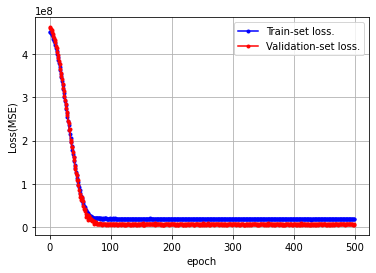

In [25]:
loss = nn_fit.history['mean_squared_error']
val_loss = nn_fit.history['val_mean_squared_error']

x_len = np.arange(len(loss))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()

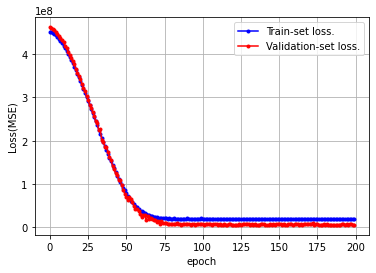

In [26]:
loss = nn_fit.history['mean_squared_error']
val_loss = nn_fit.history['val_mean_squared_error']

x_len = np.arange(len(loss))

# epoch 0 ~ epoch 50
plt.plot(x_len[:200], loss[:200], marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len[:200], val_loss[:200], marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss(MSE)')
plt.show()